In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
%env GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json 
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json


# Adress-Merkmal Datensatz erstellen

In [10]:
query_job = client.query("SELECT * from `masterarbeit-245718.ethereum_us.top40k_week1777_features`")
start = time.time()
retrievedData = query_job.result().to_dataframe()  # Waits for job to complete.
done = time.time()
elapsed = done - start
print(elapsed)

17.294569969177246


In [11]:
results = retrievedData.copy()
results.head()

,address,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,52757990803363109075085,37972196194020000000000,14330,33393,18.109966,42.197990
1,0x5d154c145db2ca90b8ab5e8fe3e716afa4ab7ff0,5175350560981998478942,5244975800350778401905,8336,22497,26.876245,72.538452
2,0x9ae49c0d7f8f9ef4b864e004fe86ac8294e20950,19370258531717665804498,23053671968774623536152,4077,30782,19.644359,148.188911
3,0xbd6d79f3f02584cfcb754437ac6776c4c6e0a0ec,3564148762741827354478,2470600314900000000000,785,5515,109.364527,753.126276
4,0xff3c260f2391a5a936df3b693b2590045ce62d62,221741486600000000000,425797346240000000000,65,422,1432.128266,8785.468750


In [9]:
m = results.memory_usage()
totalBytes = 0

for bytes_ in m:
    totalBytes = totalBytes + bytes_
    
print("Size of the account feature dataset:",totalBytes/10**6, "Megabytes")

Size of the account feature dataset: 9.58476 Megabytes


# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [14]:
featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
featureValues = results.loc[:,featureNames]
featureValues.head()

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,52757990803363109075085,37972196194020000000000,14330,33393,18.109966,42.197990
1,5175350560981998478942,5244975800350778401905,8336,22497,26.876245,72.538452
2,19370258531717665804498,23053671968774623536152,4077,30782,19.644359,148.188911
3,3564148762741827354478,2470600314900000000000,785,5515,109.364527,753.126276
4,221741486600000000000,425797346240000000000,65,422,1432.128266,8785.468750


In [36]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
featureValuesStandardised= scaler.fit_transform(featureValues)
featureValuesStandardised = pd.DataFrame(featureValuesStandardised, columns=features)
featureValuesStandardised.head()

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,21.546644,16.154493,38.485732,70.758603,-0.440679,-0.457151
1,2.092973,2.210745,22.379294,47.663649,-0.440580,-0.456809
2,7.896415,9.798311,10.934964,65.224377,-0.440661,-0.455956
3,1.434250,1.028695,2.089053,11.668924,-0.439654,-0.449140
4,0.067742,0.157487,0.154346,0.873898,-0.424803,-0.358632


# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 80% ausreicht.

In [37]:
pca2 = PCA(n_components=6)
pca2.fit(featureValuesStandardised)
pca2.explained_variance_ratio_
np.cumsum(pca2.explained_variance_ratio_)

array([0.39862491, 0.66777379, 0.81966772, 0.93250518, 0.99665139,
       1.        ])

Text(0.5, 0, 'Principal Components')

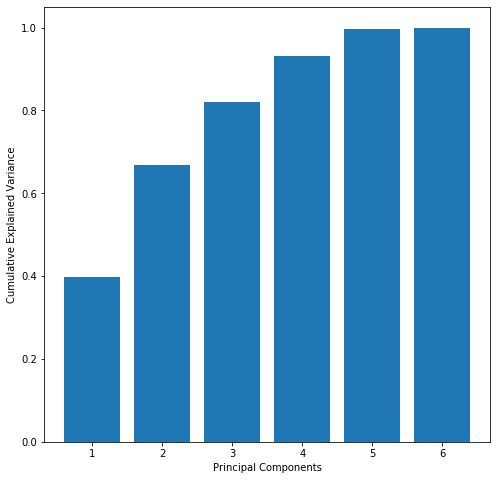

In [38]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
plt.bar([1,2,3,4,5,6], np.cumsum(pca2.explained_variance_ratio_))
ax.set_ylabel('Cumulative Explained Variance')
ax.set_xlabel('Principal Components')

In [66]:
numberOfPCAComponents = 0
explainedVarianceTargetValue = 0.8
for i in np.cumsum(pca2.explained_variance_ratio_):
    numberOfPCAComponents = numberOfComponents + 1
    if i > explainedVarianceTargetValue:
        print("Die",numberOfPCAComponents,"ersten Komponenten erklären mehr als",explainedVarianceTargetValue * 100,"% der Varianz.")
        break

Die 4 ersten Komponenten erklären mehr als 80.0 % der Varianz.


In [74]:
pca = PCA(n_components=numberOfPCAComponents)
featureValuesStandardisedAndTransformed = pca.fit_transform(featureValuesStandardised)

# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

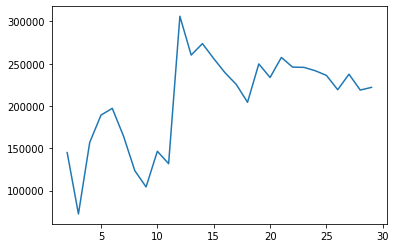

In [73]:
scores = []
numberOfCluster = []

for i in range(2,30,1):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(featureValuesStandardisedAndTransformed)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans.labels_))  

plt.plot(numberOfCluster, scores)

In [79]:
print("Based on calinski_harabasz_score the number of clusters should be", numberOfCluster[np.argmax(scores)])

Based on calinski_harabasz_score the number of clusters should be 22


# Ausreißer eliminieren

# Berechnung und Visualisierung des Entscheidungsmodells via kmeans Cluster Analyse Verfahren 

# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Identifiziere die von den Clustern repräsentierten Nutzergruppen

# Visualisiere die Interaktion zwischen den Clustern und interpretiere die Ergebnisse

# Temporary stuff

In [9]:
kmeans = KMeans(n_clusters=5) 
kmeans.fit(x_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [10]:
kmeans = KMeans(n_clusters=5) 
pca = PCA(n_components=3)
kmeans.fit(pca.fit_transform(x_transformed))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

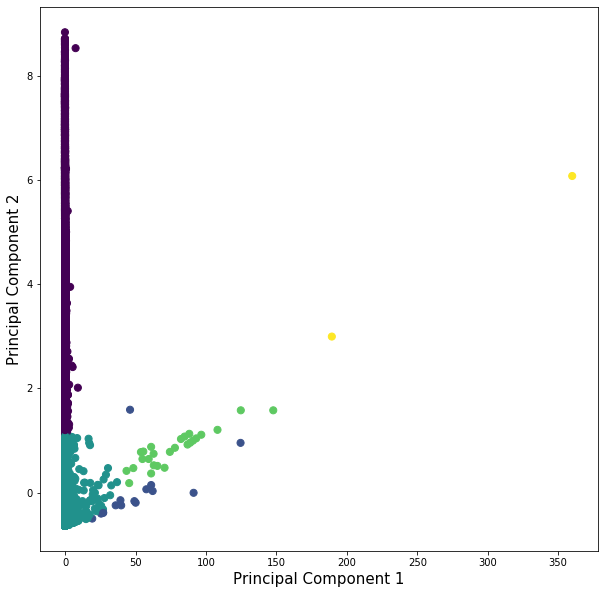

In [11]:
pca1 = PCA(n_components=2)
principalDf = pd.DataFrame(pca1.fit_transform(x_transformed), columns=["principal component 1", "principal component 2"])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], s = 50, c=kmeans.labels_)

Text(0.5, 0, 'Principal Component 3')

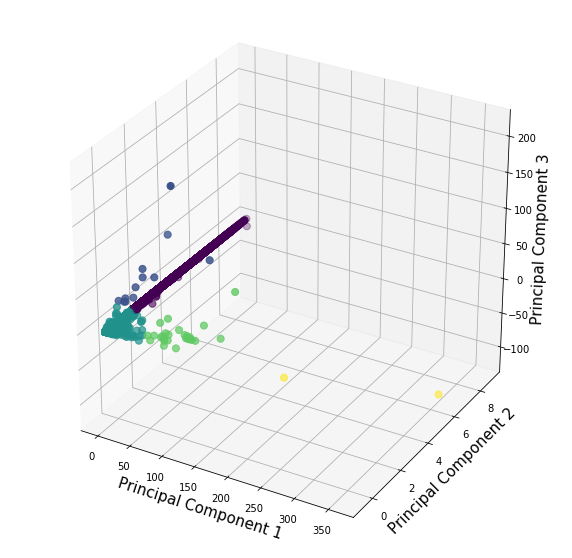

In [12]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
pca3 = PCA(n_components=3)
principalDf = pd.DataFrame(pca3.fit_transform(x_transformed), columns=["principal component 1", "principal component 2", "principal component 3"])
ax.scatter3D(principalDf.loc[:,'principal component 1'], principalDf.loc[:,'principal component 2'], principalDf.loc[:,'principal component 3'], s = 50, c=kmeans.labels_)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

In [13]:
ax?

In [14]:
for i in range(0,5,1):
    res = kmeans.labels_[kmeans.labels_ == i] 
    print("Cluster {} has {} addresses.".format(i, len(res))) 


Cluster 0 has 24132 addresses.
Cluster 1 has 15 addresses.
Cluster 2 has 146980 addresses.
Cluster 3 has 26 addresses.
Cluster 4 has 2 addresses.


In [15]:
results["cluster"] = kmeans.labels_
results["weiReceived"] = (results.loc[:,"weiReceived"] / 10**18).astype(float).round(2)
results["weiSent"] = (results.loc[:,"weiSent"] / 10**18).astype(float).round(2)
results.rename(columns={"weiReceived": "ethReceived", "weiSent": "ethSent"}, inplace=True)

In [16]:
results[results.cluster == 1].describe()

,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0
mean,12043.826667,15137.688667,16830.666667,37023.800000,27.964422,16161.601660,1.0
std,15236.629332,11768.728714,22796.945578,28722.582868,32.661344,62026.632139,0.0
min,0.000000,0.000000,1.000000,4250.000000,4.780650,0.000000,1.0
25%,809.555000,5655.995000,2197.000000,22570.000000,15.243500,16.093919,1.0
50%,5175.920000,12420.230000,8077.000000,30782.000000,19.644359,42.197990,1.0
75%,16964.825000,23467.195000,23002.000000,39656.000000,26.792000,114.088966,1.0
max,52757.990000,37972.200000,83862.000000,126470.000000,142.280537,240371.000000,1.0


In [17]:
results[results.cluster == 0].describe()

,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
count,24132.000000,24132.000000,24132.000000,24132.000000,24132.000000,24132.000000,24132.0
mean,15.912927,16.292400,2.988646,2.753771,208353.791007,208901.188795,0.0
std,230.054361,230.047559,3.432356,11.122934,130013.685657,125040.386901,0.0
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,0.150000,0.170000,2.000000,2.000000,126557.562500,118049.250000,0.0
50%,0.500000,0.640000,2.000000,2.000000,196423.500000,191356.500000,0.0
75%,3.032500,3.520000,3.000000,3.000000,291925.500000,288529.000000,0.0
max,16827.000000,19048.990000,250.000000,1039.000000,595492.000000,601969.000000,0.0


In [18]:
results[results.cluster == 2].describe()

,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
count,146980.000000,146980.000000,146980.00000,146980.000000,146980.000000,146980.000000,146980.0
mean,33.385114,34.206128,4.40943,5.599292,11516.229798,12991.419820,2.0
std,695.837665,727.152233,114.84537,145.147310,31586.259624,34510.577002,0.0
min,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,2.0
25%,0.230000,0.250000,1.00000,1.000000,0.000000,0.000000,2.0
50%,1.680000,1.730000,1.00000,1.000000,0.000000,0.000000,2.0
75%,4.500000,4.620000,2.00000,1.000000,0.000000,67.592391,2.0
max,104351.590000,71037.000000,19131.00000,21626.000000,221274.000000,220245.000000,2.0


In [19]:
results[results.cluster == 3].head()

,address,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
287,0x034f854b44d28e26386c1bc37ff9b20c6380b00d,67261.58,83958.00,9177,21,28034.700000,65.851787,3
512,0x6f50c6bff08ec925232937b204b0ae23c488402a,140498.08,138898.97,9007,9679,62.466419,67.114035,3
860,0x0d0707963952f2fba59dd06f2b425ace40b492fe,90317.24,82085.39,5249,17625,34.310429,109.843750,3
1264,0xa356c39acdbd3d3c3a732cfb3501543942c85cbd,82084.14,84750.35,24,2189,275.374771,26186.000000,3
1463,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,121453.23,98430.25,79666,5935,101.900236,7.591452,3


In [20]:
results[results.cluster == 4].head()

,address,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
1093,0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,379299.46,323899.88,7231,6580,91.818361,83.262517,4
1979,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,632879.53,610690.94,31871,16960,35.656348,18.935488,4


In [21]:
results[results.cluster == 2].head()

,address,ethReceived,ethSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions,cluster
0,0x89140e261d15fdc7c1b2fa377f5378e5960d3a31,11629.71,11649.74,1428,24,23288.521739,410.468115,2
1,0x65417798ae3c68332a5f4779afbe3e7cb6870f04,235.56,67.36,15,7,63913.666667,31964.000000,2
2,0xb830a7e63b51c2a22985c2e3b2dbcbfa838920f6,25.96,3.00,11,3,133013.000000,50356.900000,2
3,0x1550318d0bc8938b3ad0a2b000e00e14747742c0,44.86,0.00,13,13,30036.666667,46010.416667,2
4,0x0d810ff086fa4ebd29b705a2f55ac30644044571,1.00,1.00,10,5,115055.750000,51152.666667,2
